# Part 1: Getting started

In [1]:
from tensorflow.keras.utils import to_categorical
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np
%matplotlib inline

## Fetch the jet tagging dataset from Open ML

In [2]:
data = fetch_openml('hls4ml_lhc_jets_hlf')
X, y = data['data'], data['target']

### Let's print some information about the dataset
Print the feature names and the dataset shape

In [3]:
print("Feature names: ", data['feature_names'])
print()
print("X's shape: ", X.shape) 
print("Y's shape: ", y.shape)
print()
print("Labels: ", y)

Feature names:  ['zlogz', 'c1_b0_mmdt', 'c1_b1_mmdt', 'c1_b2_mmdt', 'c2_b1_mmdt', 'c2_b2_mmdt', 'd2_b1_mmdt', 'd2_b2_mmdt', 'd2_a1_b1_mmdt', 'd2_a1_b2_mmdt', 'm2_b1_mmdt', 'm2_b2_mmdt', 'n2_b1_mmdt', 'n2_b2_mmdt', 'mass_mmdt', 'multiplicity']

X's shape:  (830000, 16)
Y's shape:  (830000,)

Labels:  ['g' 'w' 't' ... 't' 'q' 'g']


As you saw above, the `y` target is an array of strings, e.g. \['g', 'w',...\] etc.
We need to make this a "One Hot" encoding for the training.
Then, split the dataset into training and validation sets

In [4]:
#One hot encoding
le = LabelEncoder()
y = le.fit_transform(y)
y = to_categorical(y, 5)

#Split the data set into training and testing set
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(y[:5])

[[1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]]


In [5]:
#Standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler().fit(X_train_val)
X_train_val = scaler.transform(X_train_val)
X_test = scaler.transform(X_test)

## Now construct a model
We'll use 3 hidden layers with 64, then 32, then 32 neurons. Each layer will use `relu` activation.
Add an output layer with 5 neurons (one for each class), then finish with Softmax activation.

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1
from callbacks import all_callbacks

In [7]:
model = Sequential()
model.add(Dense(64, input_shape=(16,), name='fc1', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='relu', name='relu1'))
model.add(Dense(32, name='fc2', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='relu', name='relu2'))
model.add(Dense(32, name='fc3', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='relu', name='relu3'))
model.add(Dense(5, name='output', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='softmax', name='softmax'))

## Train the model
We'll use Adam optimizer with categorical crossentropy loss.
The callbacks will decay the learning rate and save the model into a directory 'model_1'
The model isn't very complex, so this should just take a few minutes even on the CPU.
If you've restarted the notebook kernel after training once, set `train = False` to load the trained model.

In [8]:
#If you don't want to retrain the model, set train = False to load our trained model it.
train = True

if train:
    adam = Adam(lr=0.0001)
    model.compile(optimizer=adam, loss=['categorical_crossentropy'], metrics=['accuracy'])
    callbacks = all_callbacks(stop_patience = 1000,
                              lr_factor = 0.5,
                              lr_patience = 10,
                              lr_epsilon = 0.000001,
                              lr_cooldown = 2,
                              lr_minimum = 0.0000001,
                              outputDir = 'model_1')
    model.fit(X_train_val, y_train_val, batch_size=1024,
              epochs=30, validation_split=0.25, shuffle=True,
              callbacks = callbacks.callbacks)
    
else:
    from tensorflow.keras.models import load_model
    model = load_model('model_1/KERAS_check_best_model.h5')

## Check performance
Check the accuracy and make a ROC curve

Accuracy: 0.7507469879518073


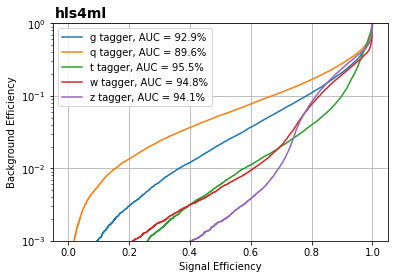

In [9]:
import plotting
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
print("Accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(model.predict(X_test), axis=1))))
plt.figure()
_ = plotting.makeRoc(X_test, y_test, le.classes_, model)

# Convert the model to FPGA firmware with hls4ml
Now we will go through the steps to convert the model we trained to a low-latency optimized FPGA firmware with hls4ml.
First, we will evaluate its classification performance to make sure we haven't lost accuracy using the fixed-point data types. 
Then we will synthesize the model with Vivado HLS and check the metrics of latency and FPGA resource usage.

## Make an hls4ml config & model
The hls4ml Neural Network inference library is controlled through a configuration dictionary.
In this example we'll use the most simple variation, later exercises will look at more advanced configuration.

In [10]:
import hls4ml

#Generate the configuration from keras model
config = hls4ml.utils.config_from_keras_model(model, granularity='model')

print()
print("Configuration dictionary: ", config)
print()

#Generate the hls model from the configuration file
hls_model = hls4ml.converters.convert_from_keras_model(model, hls_config=config, output_dir='model_1/hls4ml_prj')

Interpreting Sequential
Topology:
Layer name: fc1, layer type: Dense
  -> Activation (linear), layer name: fc1
Layer name: relu1, layer type: Activation
Layer name: fc2, layer type: Dense
  -> Activation (linear), layer name: fc2
Layer name: relu2, layer type: Activation
Layer name: fc3, layer type: Dense
  -> Activation (linear), layer name: fc3
Layer name: relu3, layer type: Activation
Layer name: output, layer type: Dense
  -> Activation (linear), layer name: output
Layer name: softmax, layer type: Activation

Configuration dictionary:  {'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}}

Interpreting Sequential
Input shape: [16]
Topology:
Layer name: fc1, layer type: Dense, current shape: [[None, 16]]
Layer name: relu1, layer type: Activation, current shape: [[None, 64]]
Layer name: fc2, layer type: Dense, current shape: [[None, 64]]
Layer name: relu2, layer type: Activation, current shape: [[None, 32]]
Layer name: fc3, layer type: Dense, current sha

Let's visualise what we created. The model architecture is shown, annotated with the shape and data types

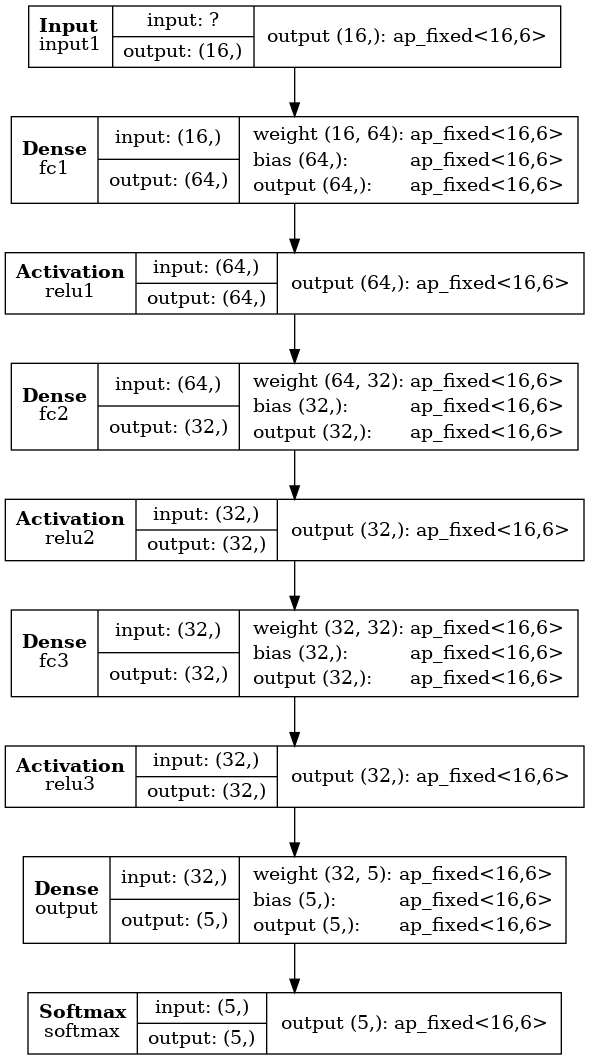

In [12]:
hls4ml.utils.plot_model(hls_model, show_shapes=True, show_precision=True, to_file=None)

## Compile, predict
Now we need to check that this model performance is still good. We compile the hls_model, and then use `hls_model.predict` to execute the FPGA firmware with bit-accurate emulation on the CPU.

In [14]:
hls_model.compile()
y_hls = hls_model.predict(X_test)

Writing HLS project
Done


## Compare
That was easy! Now let's see how the performance compares to Keras:

Keras  Accuracy: 0.7507469879518073
hls4ml Accuracy: 0.7507710843373494


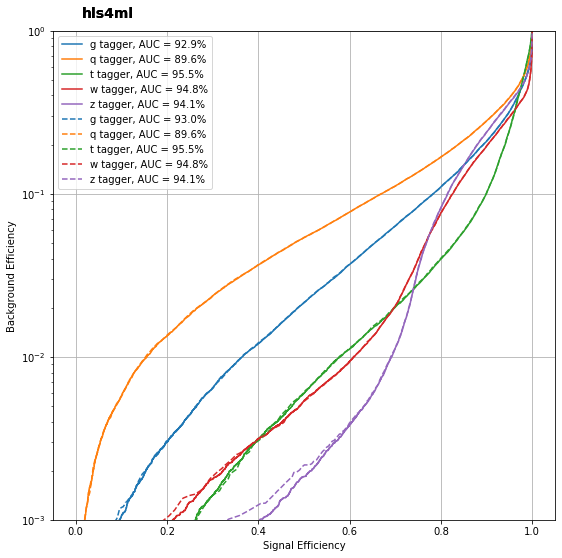

In [15]:
print("Keras  Accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(model.predict(X_test), axis=1))))
print("hls4ml Accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_hls, axis=1))))

plt.figure(figsize=(9, 9))
_ = plotting.makeRoc(X_test, y_test, le.classes_, model)
plt.gca().set_prop_cycle(None) # reset the colors
_ = plotting.makeRoc(X_test, y_test, le.classes_, hls_model, linestyle='--')

## Synthesize
Now we'll actually use Vivado HLS to synthesize the model. We can run the build using a method of our `hls_model` object.
After running this step, we can integrate the generated IP into a workflow to compile for a specific FPGA board.
In this case, we'll just review the reports that Vivado HLS generates, checking the latency and resource usage.

**This can take several minutes.**

In [16]:
hls_model.build(synth=True)

## Check the reports
Print out the reports generated by Vivado HLS. Pay attention to the Latency and the 'Utilization Estimates' sections

In [17]:
hls4ml.report.read_vivado_report('model_1/hls4ml_prj/')

Found 1 solution(s) in model_1/hls4ml_prj//myproject_prj.
Reports for solution "solution1":

C SIMULATION RESULT:
INFO: [SIM 2] *************** CSIM start ***************
INFO: [SIM 4] CSIM will launch GCC as the compiler.
   Compiling ../../../../myproject_test.cpp in debug mode
   Compiling ../../../../firmware/myproject.cpp in debug mode
   Generating csim.exe
INFO: Unable to open input/predictions file, using default input.
0.0380859 0.0986328 0.119141 0.605469 0.163086 
INFO: Saved inference results to file: tb_data/csim_results.log
INFO: [SIM 1] CSim done with 0 errors.
INFO: [SIM 3] *************** CSIM finish ***************

SYNTHESIS REPORT:
== Vivado HLS Report for 'myproject'
* Date:           Mon Jun  8 08:44:05 2020

* Version:        2018.2 (Build 2258646 on Thu Jun 14 20:25:20 MDT 2018)
* Project:        myproject_prj
* Solution:       solution1
* Product family: kintexu
* Target device:  xcku115-flvb2104-2-i


== Performance Estimates
+ Timing (ns): 
    * Summary: 
  

## Exercise
Since `ReuseFactor = 1` we expect each multiplication used in the inference of our neural network to use 1 DSP. Is this what we see? (Note that the Softmax layer should use 5 DSPs, or 1 per class)
Calculate how many multiplications are performed for the inference of this network...
(We'll discuss the outcome)